## Part 2: Uber Dataset

In [18]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.spatial import distance
from igraph import *
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import random
import math

### Q6

#### create graph

In [20]:
df = df.iloc[:, 0:4]
df = df.loc[df['month']==12]
dec_df = df.drop(['month'], axis=1)


In [21]:
dec_df.head()

,sourceid,dstid,mean_travel_time
2,758,972,953.55
5,1197,2006,1213.18
6,2652,620,828.92
7,2427,2693,1742.80
8,2653,610,699.03


In [22]:
init_dec_df = dec_df.copy()
init_dec_df['sourceid'] = init_dec_df['sourceid'].astype(str)
init_dec_df['dstid'] = init_dec_df['dstid'].astype(str)

In [23]:
tuples_init = [tuple(x) for x in init_dec_df.values]
g_init = Graph.TupleList(tuples_init, directed = False, edge_attrs = 'weight')

In [24]:
summary(g_init)

IGRAPH UNW- 2649 1692450 -- 
+ attr: name (v), weight (e)


#### clear the duplicates

In [25]:
dec_array = np.asarray(dec_df) 
existing_paths = {}
existing_locations = np.unique(np.concatenate([dec_array[:,0],dec_array[:,1]]))
counter = 0
for row in dec_array:
    locations = tuple(np.sort(row[0:2]))
    if locations in existing_paths:
        existing_paths[locations].append(row[2])
        counter += 1
    else:
        existing_paths[locations] = [row[2]]

with open(directory + '/s.txt','w') as f:
    for locations in existing_paths:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),np.mean(existing_paths[locations]))
        f.write(string)

In [26]:
g = Graph.Read(directory + '/december_data.txt', format='ncol', directed=False)
gcc = g.components().giant()
summary(g)
summary(gcc)

IGRAPH UNW- 2649 1004955 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 2649 1004955 -- 
+ attr: name (v), weight (e)


#### get the json file

In [27]:
with open(directory+'/los_angeles_censustracts.json', 'r') as f:
    data_json = json.load(f)
data_json.keys()

dict_keys(['type', 'features'])

In [28]:
geo_df = data_json['features']

In [29]:
colname = ['ID', 'Display_Name', 'Longitude', 'Latitude']
map_df = pd.DataFrame(columns = colname)
map_df

,ID,Display_Name,Longitude,Latitude


In [30]:
print(geo_df[0].keys())
print(geo_df[0]['properties'].keys())
print(geo_df[0]['geometry'].keys())

dict_keys(['type', 'properties', 'geometry'])
dict_keys(['MOVEMENT_ID', 'TRACT', 'DISPLAY_NAME'])
dict_keys(['type', 'coordinates'])


In [31]:
i = 1
for item in geo_df:
    map_df.loc[i, 'ID'] = item['properties']['MOVEMENT_ID']
    map_df.loc[i, 'Display_Name'] = item['properties']['DISPLAY_NAME']
    coors = item['geometry']['coordinates'][0][0]
    if isinstance(coors[0], list):
        longitude = 0
        latitude = 0

        for coor in coors:
            longitude = longitude+coor[0]
            latitude = latitude+coor[1]
            
        longitude = longitude/len(coors)
        latitude = latitude/len(coors)     
    else:
        coors = item['geometry']['coordinates'][0]
        longitude = 0
        latitude = 0

        for coor in coors:
            longitude = longitude+coor[0]
            latitude = latitude+coor[1]
            
        longitude = longitude/len(coors)
        latitude = latitude/len(coors)
#         longitude = coors[0]
#         latitude = coors[1]
        
    map_df.loc[i, 'Longitude'] = longitude
    map_df.loc[i, 'Latitude'] = latitude    
    i+=1

In [32]:
map_df

,ID,Display_Name,Longitude,Latitude
1,1,Census Tract 480302,-118.121,34.1031
2,2,Census Tract 480303,-118.138,34.0965
3,3,Census Tract 480304,-118.131,34.0963
4,4,Census Tract 480400,-118.132,34.1035
5,5,Census Tract 480500,-118.145,34.0987
...,...,...,...,...
2712,2712,Census Tract 087902,-117.988,33.792
2713,2713,Census Tract 110006,-118.078,33.7962
2714,2714,Census Tract 110007,-118.083,33.7881
2715,2715,Census Tract 110008,-118.08,33.781


#### map geo_coordinates with map information

In [33]:
gvs = g.vs()
for v in gvs:
    v["Display_Name"] = map_df.loc[map_df["ID"] == v['name']].iloc[:,1].values[0]
    v["Coordinate"] = (map_df.loc[map_df["ID"] == v['name']].iloc[:,2].values[0],
                       map_df.loc[map_df["ID"] == v['name']].iloc[:,3].values[0])
gcc = g.components().giant()                    

In [34]:
summary(g)
summary(gcc)


IGRAPH UNW- 2649 1004955 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)
IGRAPH UNW- 2649 1004955 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)


### Q7

In [35]:
mst = gcc.spanning_tree(weights = gcc.es['weight'])
vertices = mst.vs()
summary(mst)

IGRAPH UNW- 2649 2648 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)


In [36]:
for i in range(6):
    r = random.randint(0, len(vertices))
    print("Random point{}:".format(i+1))
    print("One endpoint:\nID: {}, Display_Name: {}".format(vertices[r]["name"], vertices[r]["Display_Name"]))
    print("Coordinate: {}\n".format(vertices[r]["Coordinate"]))
    print("Another endpoint:\nID: {}, Display_Name: {}".format(vertices[r+1]["name"], vertices[r+1]["Display_Name"]))
    dist = distance.euclidean(vertices[r]['Coordinate'], vertices[r+1]['Coordinate'])*69
    
    print("Coordinate: {}\n".format(vertices[r+1]["Coordinate"]))
    print('Distance between two points: {} miles. '.format(dist))
    print('='*60)
    

Random point1:
One endpoint:
ID: 1589, Display_Name: Census Tract 272202
Coordinate: (-118.43792160000001, 33.996997666666665)

Another endpoint:
ID: 1579, Display_Name: Census Tract 271500
Coordinate: (-118.43632061290322, 34.01698956451613)

Distance between two points: 1.3838571249385634 miles. 
Random point2:
One endpoint:
ID: 296, Display_Name: Census Tract 432402
Coordinate: (-118.02630931250002, 34.085936640625)

Another endpoint:
ID: 287, Display_Name: Census Tract 430003
Coordinate: (-117.94347146212125, 34.160677848484866)

Distance between two points: 7.69848235500906 miles. 
Random point3:
One endpoint:
ID: 1137, Display_Name: Census Tract 192420
Coordinate: (-118.3104568, 34.0794782)

Another endpoint:
ID: 1191, Display_Name: Census Tract 201504
Coordinate: (-118.1726535, 34.08173496551724)

Distance between two points: 9.509702679599148 miles. 
Random point4:
One endpoint:
ID: 650, Display_Name: Census Tract 575002
Coordinate: (-118.14216908474576, 33.78753891525424)

Ano

### Q8

In [37]:
def is_trangle(max_index, combined_set, *args):
    current_set = ()
    indices = []
    weights = []
    for index in range(3):
        indices.append(random.randint(0, max_index))
    current_set = tuple(sorted(indices))
    
    while current_set in combined_set:
        for index in range(3):
            indices.append(random.randint(0, max_index))
        current_set = tuple(sorted(indices))
    
    for e in current_set:
        weights.append(gcc_es[e]['weight'])
    if (weights[0] < weights[1] + weights[2] and weights[1] < weights[0] + weights[2] and weights[2] < weights[0] + weights[1]):
        return True, weights, current_set
    else:
        return False, weights, current_set

    

In [38]:
max_idx = len(gcc.vs()) - 1
gcc_vertices = gcc.vs()
gcc_es = EdgeSeq(gcc)
num_triangle = 1000
total_set = set()
num_satisfied = 0
num = 0

In [39]:
def result_show(satisify):
    print('='*50,'triangle',num+1)
    
    edges = []
    start_nodes = []
    end_nodes = []
    for e in current_set:
        edges.append(gcc_es[e])
        
        source_vertex = gcc.vs[gcc_es[e].source]
        target_vertex = gcc.vs[gcc_es[e].target]
        
        start_nodes.append(source_vertex['Display_Name'])
        end_nodes.append(target_vertex['Display_Name'])
    for i in range(3):
        print(start_nodes[i], '---', end_nodes[i])
    if satisify:
        print('Is Triangle')
    else:
        print('Not a Triangle')

In [40]:
while num<num_triangle:
    for i in range(3):
        satisfy, weights, current_set = is_trangle(max_idx, total_set)
        if satisfy:
            break
    total_set.add(current_set)
    if satisfy:
        num_satisfied+=1
    if num%100 == 0:
        result_show(satisfy)
    num+=1
print('The percentage of being a triangle is: ', str(num_satisfied/num_triangle))

================================================== triangle 1
Census Tract 534101 --- Census Tract 237102
Census Tract 500403 --- Census Tract 480101
Census Tract 702102 --- Census Tract 125320
Is Triangle
================================================== triangle 101
Census Tract 120400 --- Census Tract 143400
Census Tract 275102 --- Census Tract 188201
Census Tract 405701 --- Census Tract 433700
Is Triangle
================================================== triangle 201
Census Tract 231720 --- Census Tract 553702
Census Tract 181300 --- Census Tract 463602
Census Tract 218800 --- Census Tract 310701
Is Triangle
================================================== triangle 301
Census Tract 300502 --- Census Tract 310702
Census Tract 208000 --- Census Tract 481101
Census Tract 543400 --- Census Tract 603302
Is Triangle
================================================== triangle 401
Census Tract 601700 --- Census Tract 207101
Census Tract 197300 --- Census Tract 601600
Census Tract 18310

### Q9

In [41]:
def create_a_walk(mst, walk, visited, mst_vset, *args):
    current_node = walk[-1]
    if len(walk) > 1 and current_node == walk[0]:
        return True
    else:
        edges = mst.es.select(_between = ([current_node],mst_vset))
        for edge in edges:
            if not edge in visited:
                visited.add(edge)
                node_tuple = edge.tuple
                if node_tuple[0] == current_node:
                    next_node = node_tuple[1]
                else:
                    next_node = node_tuple[0]

                walk.append(next_node)
                next_walk = create_a_walk(mst, walk, visited, mst_vset)
                if next_walk:
                    return True
                else:
                    walk.pop()
                    visited.remove(edge)
        return False
    

In [42]:
def eulerian_walk(mst, v, mst_vset, *args):    
    edges = mst.es.select(_source_in = [v])
    if len(edges) == 0: 
        return [v]
    else:
        walk = [v]
        visited = set()
        create_a_walk(mst, walk, visited, mst_vset)
        for i in range(len(walk) - 1):
            walk_edges = mst.es.select(_between = ([walk[i]], [walk[i+1]]))
            mst.delete_edges(walk_edges[0])
        results = []
        for node in walk:
            next_ewalk = eulerian_walk(mst, node, mst_vset)
            for e in next_ewalk:
                results.append(e)
        return results

In [43]:
def approximate_algorithm(g, *args):
    # find the minimum spanning tree T
    mst = g.spanning_tree(weights = gcc.es["weight"])
    edges = mst.es()
    edge_list = []
    for edge in edges:
        edge_list.append(edge.tuple)
        
    mst_temp = mst.as_undirected()
    mst_temp.add_edges(edge_list)
    
    mst_double = mst_temp.as_undirected()

    e_walk = eulerian_walk(mst_double, 0, mst_double.vs())

    path = []
    visited = set()
    for i in e_walk:
        if not i in visited:
            path.append(i)
            visited.add(i)
            
    total_weight = 0
    final_path = []
    for i in range(len(path) - 1):
        i_1 = path[i]
        i_2 = path[i + 1]

        edges = g.es.select(_between = ([i_1], [i_2]))
        if len(edges) > 0:
            total_weight += edges[0]['weight']
            final_path.append(i_1)
        else:
            total_weight += gcc.shortest_paths([i_1], [i_2], weights = gcc.es()['weight'])[0][0]
    return mst, total_weight, final_path

In [44]:
import sys
sys.setrecursionlimit(10000)

appro_mst, total_weight, final_path = approximate_algorithm(gcc)


In [45]:
print('total weight:', total_weight)
print('upper bound:', total_weight / sum(mst.es['weight']))

total weight: 465542.44000000047
upper bound: 1.7300968643282872


### Q10

In [46]:
final_locations = []
for i in final_path:
    final_locations.append(appro_mst.vs[i]['Display_Name'])

In [47]:
longitude = []
latitude = []

for i in final_path:
    longitude.append(appro_mst.vs[i]['Coordinate'][0])
    latitude.append(appro_mst.vs[i]['Coordinate'][1])

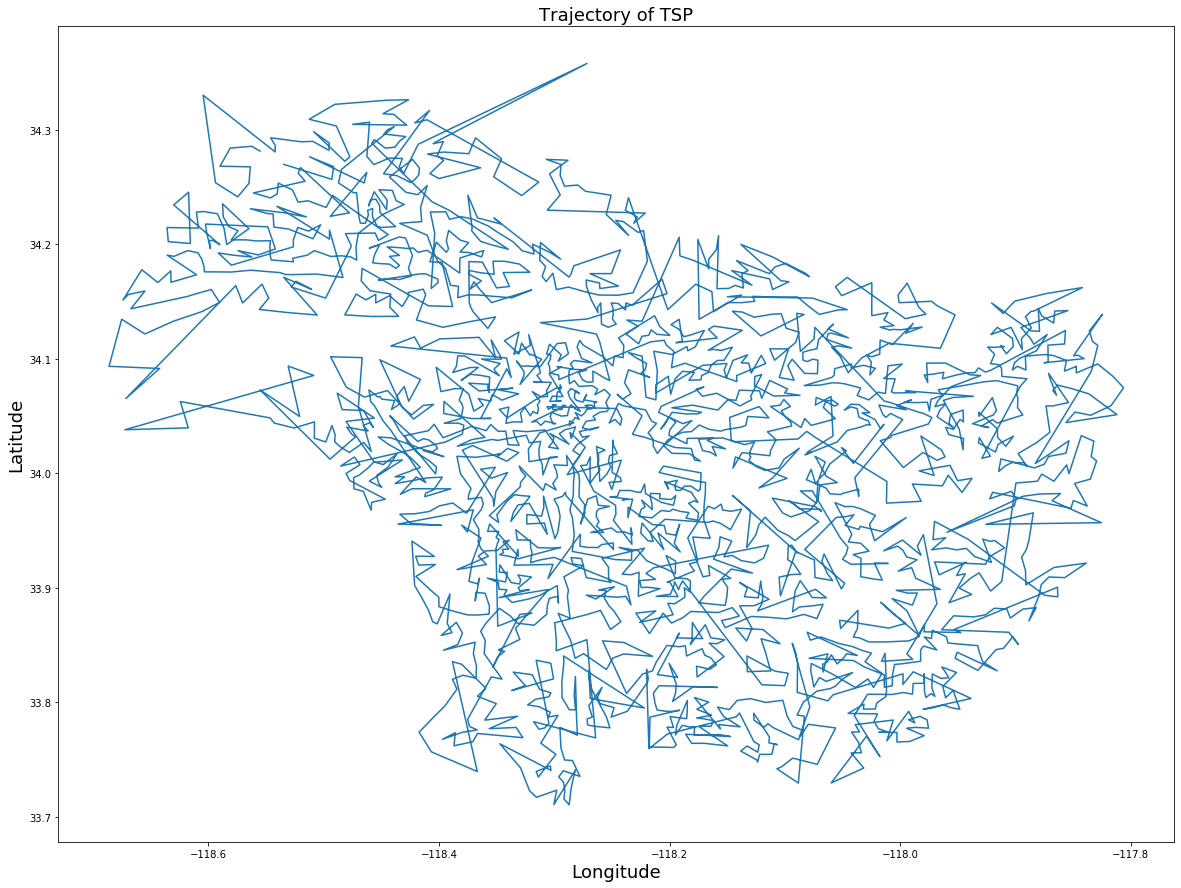

In [48]:
plt.figure(figsize = (20, 15))

plt.plot(longitude, latitude)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.title('Trajectory of TSP', fontsize = 18)
plt.show()

### Q11

In [49]:
coor_df = map_df.copy()
coor_df = coor_df.iloc[:, [2,3]]
coor_list = []
for i in range(len(coor_df)):
    coor_list.append([coor_df.iloc[i, 0], coor_df.iloc[i, 1]])
coor_arr = np.asarray(coor_list)
tri = Delaunay(coor_arr)

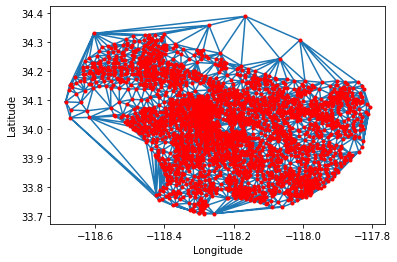

In [50]:
plt.triplot(tri.points[:, 0], tri.points[:, 1], tri.simplices.copy())
plt.triplot(tri.points[:, 0], tri.points[:, 1], 'r.')
#plt.plot(tri.points[:, 0], tri.points[:, 1], 'o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [51]:
coor_list_2 = []
# gcc_vertices = gcc.vs()
for v in gcc_vertices:
    coor_list_2.append(list(v['Coordinate']))
coor_arr_2 = np.array(coor_list_2)



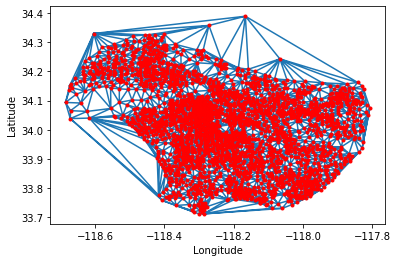

In [52]:
tri_2 = Delaunay(coor_arr_2)
plt.triplot(tri_2.points[:, 0], tri_2.points[:, 1], tri_2.simplices.copy())
plt.triplot(tri_2.points[:, 0], tri_2.points[:, 1],'r.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Q12

In [53]:
def get_flow(dist, time):
    speed = dist/time
    flow = 2/(0.003/speed + 1/1800)
    return flow
def get_edge_flow(g):
    g_Es = EdgeSeq(g)
    for es in g_Es:
        vertex1 = es.tuple[0]
        vertex2 = es.tuple[1]
        coor_1 = gcc.vs[vertex1]['Coordinate']
        coor_2 = gcc.vs[vertex2]['Coordinate']
        dist = 69*distance.euclidean(coor_1, coor_2)
        time = es['weight']/3600
        if dist==0:
            continue
        flow = get_flow(dist, time)
        es['Flow'] = flow
    return g

In [54]:
gcc_flow = get_edge_flow(gcc)
gcc_flow.summary()

'IGRAPH UNW- 2649 1004955 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), Flow (e), weight (e)'

In [64]:
gcc_Es = EdgeSeq(gcc_flow)
for es in gcc_Es:
    if es['Flow'] is not None:
        flow = es['Flow']
    else:
        continue

In [65]:
# total_flow, n = 0, 0
# for es in gcc_Es:
#     if es['Flow'] is not None:
#         total_flow += es['Flow']
#         n+=1
#     else:
#         continue
# mean_flow = total_flow/n
# print('The mean of the flow is {:.0f} cars/(hour.road)'.format(mean_flow))

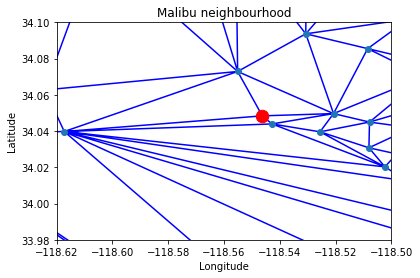

In [202]:
x = tri_2.points[:,0]
y = tri_2.points[:,1]
plt.triplot(x, y, tri_2.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Malibu neighbourhood")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.ylim((34.04-0.06,34.04+0.06))
plt.xlim((-118.56-0.06,-118.56+0.06))

plt.plot(-118.54625915050165, 34.048403046822735, 'r.', ms = 25)
plt.show()

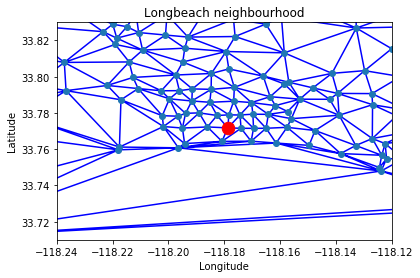

In [203]:
x = tri_2.points[:,0]
y = tri_2.points[:,1]
plt.triplot(x, y, tri_2.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Longbeach neighbourhood")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.ylim((33.77-0.06,33.77+0.06))
plt.xlim((-118.18-0.06,-118.18+0.06))

plt.plot(-118.17865950000001, 33.771767700000005, 'r.', ms=25)
plt.show()

### Q13

In [204]:
def get_coor_2(g, source_coor, dest_coor):
    for i in range(len(g.vs())):
        if round(g.vs[i]['Coordinate'][0], 2)==source_coor[0] and round(g.vs[i]['Coordinate'][1],2) == source_coor[1]:
            source_id = i
        if round(g.vs[i]['Coordinate'][0],2) == dest_coor[0] and round(g.vs[i]['Coordinate'][1],2) == dest_coor[1]:
            dest_id = i
    return source_id, dest_id

In [205]:
def get_coor(g, source_coor, dest_coor):
    for i in range(len(g.vs())):
        if abs(round(g.vs[i]['Coordinate'][0], 2)+abs(source_coor[0]))<=0.02 and abs(round(g.vs[i]['Coordinate'][1],2)-source_coor[1])<=0.01:
            source_id = i
        if round(g.vs[i]['Coordinate'][0],2) == dest_coor[0] and round(g.vs[i]['Coordinate'][1],2) == dest_coor[1]:
            dest_id = i
    return source_id, dest_id

In [206]:
source_coor = [-118.56, 34.07]
dest_coor = [-118.18, 33.79]
source_id, dest_id = get_coor(gcc, source_coor, dest_coor)

In [207]:
print('The ID of source point is: {}, the ID of destination point is:{}'.format(source_id, dest_id))

The ID of source point is: 2124, the ID of destination point is:2403


In [208]:
# soure_id = 1700
# dest_id = 654

dest_coor = gcc_flow.vs[dest_id]['Coordinate']
source_coor = gcc_flow.vs[source_id]['Coordinate']
print(dest_coor, source_coor)

(-118.17633086206894, 33.79408941379311) (-118.55510068503939, 34.07289098425196)


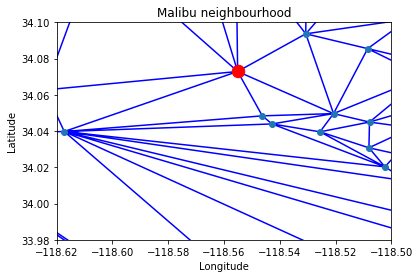

In [209]:
x = tri_2.points[:,0]
y = tri_2.points[:,1]
plt.triplot(x, y, tri_2.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Malibu neighbourhood")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.ylim((34.04-0.06,34.04+0.06))
plt.xlim((-118.56-0.06,-118.56+0.06))

plt.plot(-118.55510068503939, 34.07289098425196, 'r.', ms = 25)
plt.show()

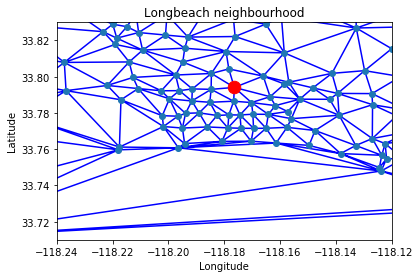

In [210]:
x = tri_2.points[:,0]
y = tri_2.points[:,1]
plt.triplot(x, y, tri_2.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Longbeach neighbourhood")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.ylim((33.77-0.06,33.77+0.06))
plt.xlim((-118.18-0.06,-118.18+0.06))

plt.plot(-118.17633086206894, 33.79408941379311, 'r.', ms=25)
plt.show()

In [211]:
gcc_maxflow = gcc_flow.maxflow(source_id, dest_id, capacity = 'Flow')
gcc_maxflow_value = gcc.maxflow_value(source_id, dest_id, capacity = 'Flow')
print(gcc_maxflow_value)

gcc_disjointed_path = gcc.edge_disjoint_paths(source_id, dest_id)
print(gcc_disjointed_path)

26041.56730277809
7


### Q14

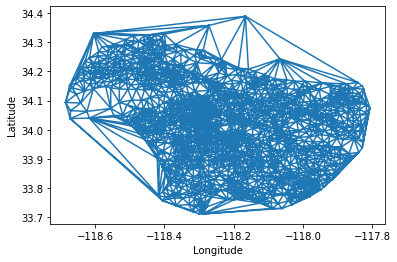

In [212]:
plt.triplot(tri_2.points[:, 0], tri_2.points[:, 1], tri_2.simplices.copy())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [213]:
triangles = tri_2.simplices
triangles_set = set()
for triangle in triangles:
    a = (triangle[0], triangle[1])
    b = (triangle[1], triangle[2])
    c = (triangle[2], triangle[0])
    triangles_set.add(a)
    triangles_set.add(b)
    triangles_set.add(c) 

In [214]:
gcg_Es = EdgeSeq(gcc)
edge_to_time = {}
for es in gcg_Es:
    edge_to_time[es.tuple] = es['weight']

In [215]:
edge_to_id = []
for es in gcg_Es:
    edge_to_id.append(es.tuple[0])
    edge_to_id.append(es.tuple[1])

In [216]:
edge_set = set()
for es in gcg_Es:
    edge_set.add(es.tuple)

In [217]:
tri_Edge_totime = {}
for tri_edge in triangles_set:
    time = edge_to_time.get(tri_edge)
    if time:
        tri_Edge_totime[tri_edge] = time
    else:
        edge_r = tuple((tri_edge[1], tri_edge[0]))
        time = edge_to_time.get(edge_r)
        if time:
            tri_Edge_totime[edge_r] = time

In [218]:
THRESHOLD = 600
threshold_triEdge_totime = {}
for key, time in tri_Edge_totime.items():
    if time<THRESHOLD:
        threshold_triEdge_totime[key] = time

In [219]:
print('The edge number after purning:', len(threshold_triEdge_totime))

The edge number after purning: 7719


#### Prune

In [220]:
colname_2 = ['S', 'D', 'weight']
tri_df = pd.DataFrame(columns=colname_2)

n = 0
for key, time in threshold_triEdge_totime.items():
    tri_df.loc[n, 'S'] = str(key[0])
    tri_df.loc[n, 'D'] = str(key[1])
    tri_df.loc[n, 'weight'] = time
    n+=1

In [221]:
tuple_p = [tuple(x) for x in tri_df.values]
gcg_prune = Graph.TupleList(tuple_p, directed = False, edge_attrs = 'weight')
gcg_prune.summary()

'IGRAPH UNW- 2647 7719 -- \n+ attr: name (v), weight (e)'

In [222]:
gcg_vs_p = gcg_prune.vs()
for v in gcg_vs_p:
    idx = int(v['name'])-1
    v['Coordinate'] = (map_df.iloc[idx, 2], map_df.iloc[idx, 3])
    v['Display_Name'] = map_df.iloc[idx, 1]
gcg_prune.summary()

'IGRAPH UNW- 2647 7719 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)'

#### plot

In [223]:
coor_list_p = []
gcg_vs_p = gcg_prune.vs()
for v in gcg_vs_p:
    coor_list_p.append(list(v['Coordinate']))
coor_arr_p = np.array(coor_list_p)
tri_p = Delaunay(coor_arr_p)

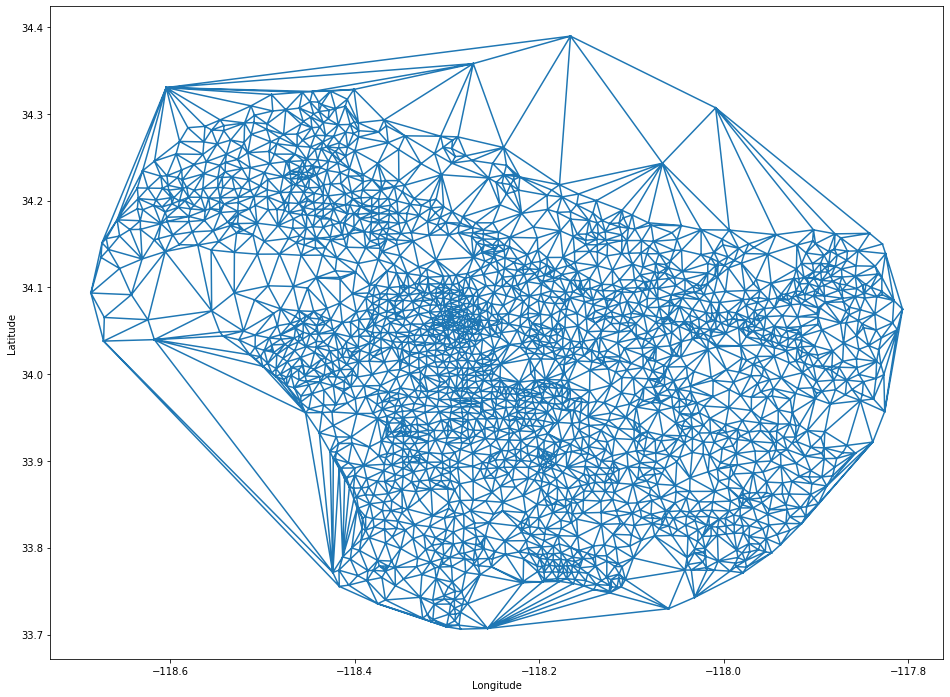

In [224]:
plt.figure(figsize=(16, 12))
plt.triplot(tri_p.points[:, 0], tri_p.points[:, 1], tri_p.simplices)
#plt.plot(tri_p.points[:, 0], tri_p.points[:, 1], 'o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

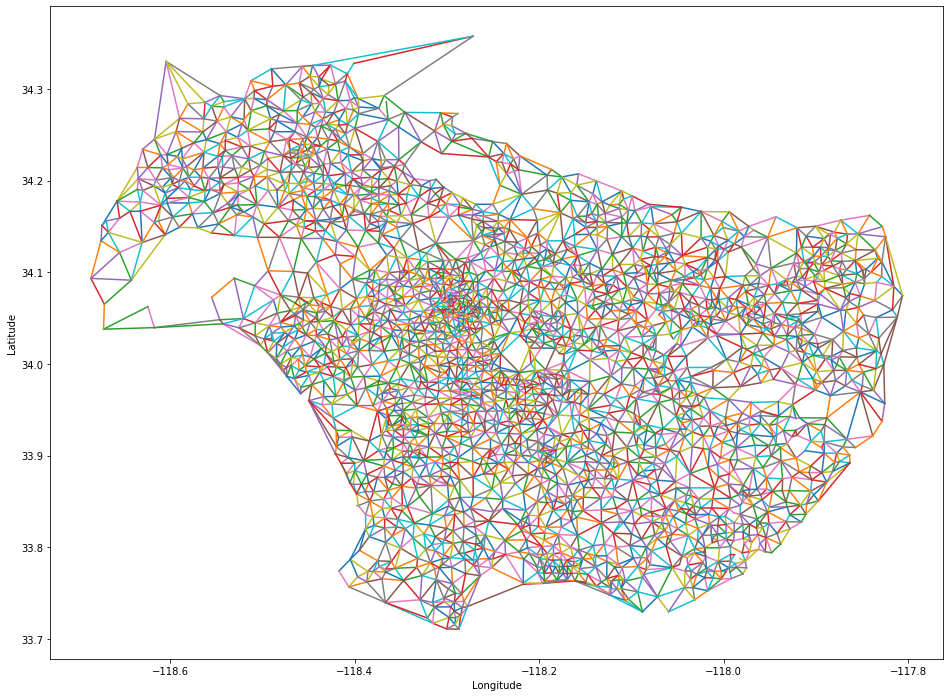

In [225]:
plt.figure(figsize=(16, 12))
gvs = gcc.vs()
def threshold_plot(to_time_list, coor_list, gvs):
    for key in to_time_list:
        point1 = key[0]
        point1_org = int(gvs[point1]['name'])-1
        point1_coor = [coor_list.iloc[point1_org, 0], coor_list.iloc[point1_org, 1]]

        point2 = key[1]
        point2_org = int(gvs[point2]['name'])-1
        point2_coor = [coor_list.iloc[point2_org, 0], coor_list.iloc[point2_org, 1]]

        points = np.array([point1_coor, point2_coor])
        plt.plot(points[:, 0], points[:, 1])
threshold_plot(threshold_triEdge_totime, coor_df, gvs)    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Q15

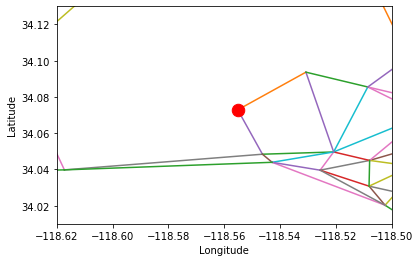

In [226]:
plt.figure()
threshold_plot(threshold_triEdge_totime, coor_df, gvs)    
plt.xlim((round(source_coor[0], 2)-0.06, round(source_coor[0], 2)+0.06))
plt.ylim((round(source_coor[1], 2)-0.06, round(source_coor[1], 2)+0.06))
plt.plot(source_coor[0], source_coor[1], 'r.', ms = 25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

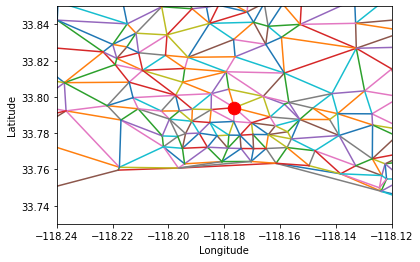

In [227]:
plt.figure()
threshold_plot(threshold_triEdge_totime, coor_df, gvs)    
plt.xlim((round(dest_coor[0], 2)-0.06, round(dest_coor[0], 2)+0.06))
plt.ylim((round(dest_coor[1], 2)-0.06, round(dest_coor[1], 2)+0.06))
plt.plot(dest_coor[0], dest_coor[1], 'r.', ms = 25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [228]:
source_coor = [-118.56, 34.07]
dest_coor = [-118.18, 33.79]
source_id_2, dest_id_2 = get_coor(gcg_prune, source_coor, dest_coor)
print(source_id_2)
print(dest_id_2)

371
2598


In [229]:
gcg_Es_p = EdgeSeq(gcg_prune)
gcg_flow_p = get_edge_flow(gcg_prune)
gcg_prune.summary()

'IGRAPH UNW- 2647 7719 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), Flow (e), weight (e)'

In [230]:
gsg_prune_flow = gcg_prune.maxflow_value(source_id_2, dest_id_2, capacity = 'Flow')
gcg_disjointed_path_p = gcg_prune.edge_disjoint_paths(source_id_2, dest_id_2)
print(gsg_prune_flow)
print(gcg_disjointed_path_p)


21318.062932045126
2


## Define the project: EDA on our LA dataset

#### Get to know our dataset again 

In [101]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import *
import seaborn as sns

from mpl_toolkits.basemap import Basemap

In [102]:

df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144062 entries, 0 to 5144061
Data columns (total 7 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   sourceid                                  int64  
 1   dstid                                     int64  
 2   month                                     int64  
 3   mean_travel_time                          float64
 4   standard_deviation_travel_time            float64
 5   geometric_mean_travel_time                float64
 6   geometric_standard_deviation_travel_time  float64
dtypes: float64(4), int64(3)
memory usage: 274.7 MB


In [103]:
df_2.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,17,296,10,1109.36,492.50,1021.90,1.48
1,28,186,10,1625.16,475.09,1565.73,1.30
2,758,972,12,953.55,269.46,916.93,1.33
3,1212,547,10,2053.39,648.63,1953.97,1.37
4,1299,1221,11,1467.54,539.64,1370.82,1.45


In [104]:
df_2.isnull().sum()

sourceid                                    0
dstid                                       0
month                                       0
mean_travel_time                            0
standard_deviation_travel_time              0
geometric_mean_travel_time                  0
geometric_standard_deviation_travel_time    0
dtype: int64

 Great, no missing value, let's look deeper

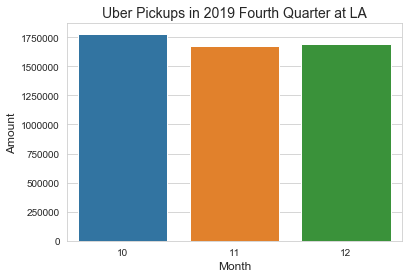

In [70]:
sns.set_style('whitegrid')
ax = sns.countplot(x = 'month', data = df_2)
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Amount', fontsize = 12)
ax.set_title('Uber Pickups in 2019 Fourth Quarter at LA', fontsize = 14)
plt.style.use({'figure.figsize':(12, 8)})
plt.show()

#### It seems our data is a little tedious. Let's look at Geometry dataset

/Users/bournsh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


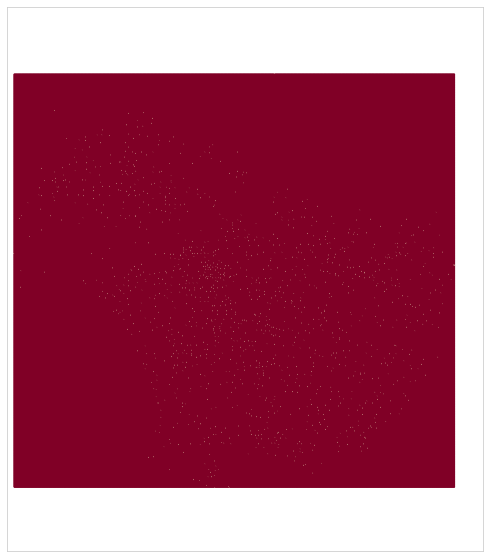

In [71]:
west, south, east, north = -118.70, 33.60, -117.75, 34.50
fig = plt.figure(figsize = (14, 10))
hm = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='h')
x, y = hm(map_df['Longitude'].values, map_df['Latitude'].values)
hm.hexbin(x, y, gridsize = 1000, bins = 'log', cmap = cm.YlOrRd_r)

Nothing seems happened. However, look carefully, some spots were shown. Maybe our dataset's size is too small. Let's see.

In [72]:
map_df.size

10864

So let's change a way of showing the map

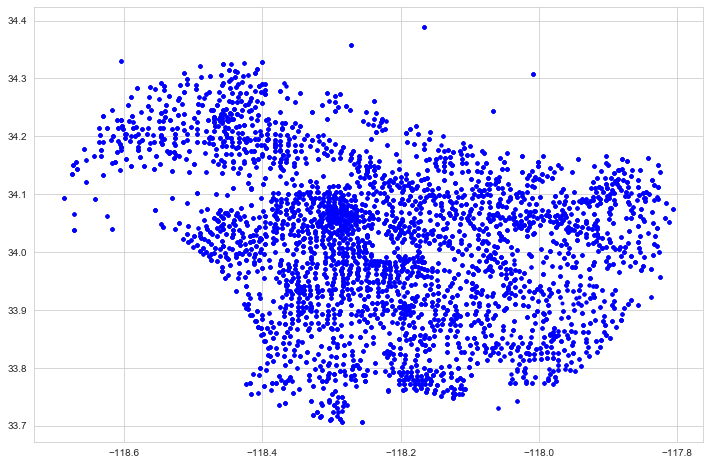

In [73]:
plt.figure()
ES_prune = EdgeSeq(gcg_prune)
VS_prune = gcg_prune.vs()
for es in ES_prune:
    v1_idx = es.tuple[0]
    v2_idx = es.tuple[1]
    v1_coordinate = VS_prune[v1_idx]['Coordinate']
    v2_coordinate = VS_prune[v2_idx]['Coordinate']
    points = np.array([v1_coordinate, v2_coordinate])
    plt.plot(points[:,0], points[:,1], 'b.')

Cool, we have LA

Let's change a bigger dataset, see if we can get the charming heat map

## Define the project: Use a Bigger Dataset: EDA Uber dataset in NYC

#### Know the dataset first

In [74]:
df_nyc = pd.read_csv(directory +'/uber_NYC.csv')

In [75]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829275 entries, 0 to 829274
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  829275 non-null  object 
 1   Lat        829275 non-null  float64
 2   Lon        829275 non-null  float64
 3   Base       829275 non-null  object 
dtypes: float64(2), object(2)
memory usage: 25.3+ MB


In [76]:
df_nyc.head()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512


In [77]:
df_nyc.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

#### EDA !

In [78]:
df_nyc['Date/Time'] = pd.to_datetime(df_nyc['Date/Time'], format = "%m/%d/%Y %H:%M:%S")
df_nyc['Day_of_Week'] = df_nyc['Date/Time'].dt.day_name()
df_nyc['Day_of_Month'] = df_nyc['Date/Time'].dt.day

In [79]:
df_nyc.head()

,Date/Time,Lat,Lon,Base,Day_of_Week,Day_of_Month
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,Friday,1
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,Friday,1
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,Friday,1
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,Friday,1
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,Friday,1


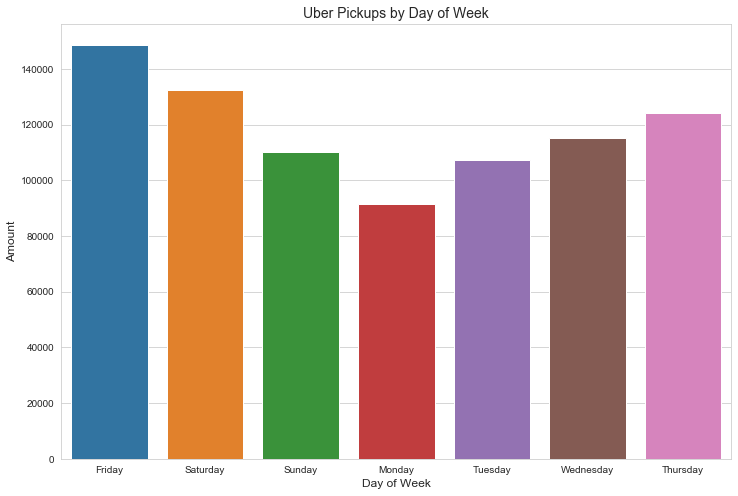

In [80]:
sns.set_style('whitegrid')
ax = sns.countplot(x = 'Day_of_Week', data = df_nyc)
ax.set_xlabel('Day of Week', fontsize = 12)
ax.set_ylabel('Amount', fontsize = 12)
ax.set_title('Uber Pickups by Day of Week', fontsize = 14)
plt.style.use({'figure.figsize':(12, 8)})
plt.show()

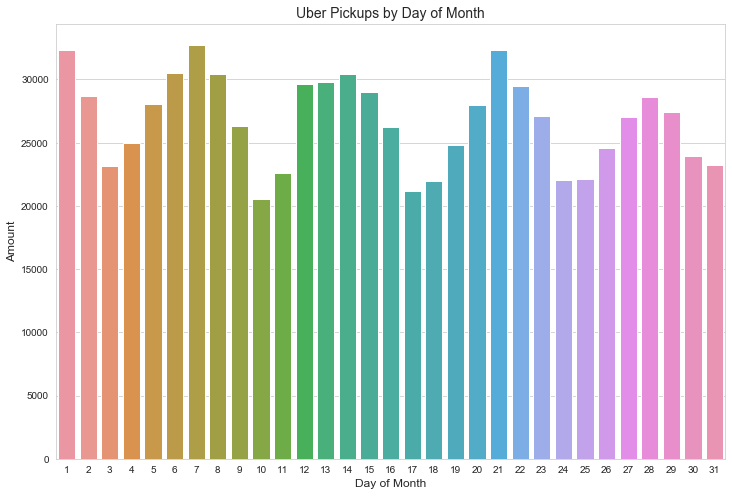

In [81]:
sns.set_style('whitegrid')
ax = sns.countplot(x = 'Day_of_Month', data = df_nyc)
ax.set_xlabel('Day of Month', fontsize = 12)
ax.set_ylabel('Amount', fontsize = 12)
ax.set_title('Uber Pickups by Day of Month', fontsize = 14)
plt.style.use({'figure.figsize':(12, 8)})
plt.show()

#### Get the Heatmap of Geometry Information

/Users/bournsh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


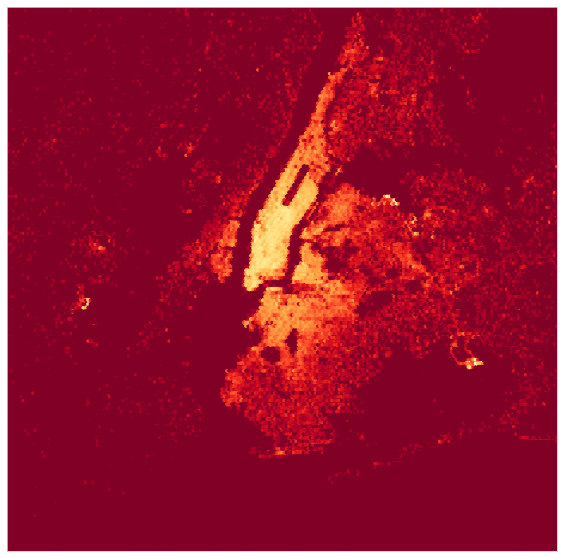

In [82]:
west, south, east, north = -74.26, 40.50, -73.70, 40.92
fig = plt.figure(figsize = (14, 10))
hm = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='h')
x, y = hm(df_nyc['Lon'].values, df_nyc['Lat'].values)
hm.hexbin(x, y, gridsize = 1000, bins = 'log', cmap = cm.YlOrRd_r)